# Import Necessary Library

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-07-13 21:56:05.971989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 21:56:05.972097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 21:56:06.094093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


# Reading the Data

In [2]:
data_dir = '/kaggle/input/blood-cells-image-dataset/bloodcells_dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    if fold in ['ig', 'neutrophil']:
        continue
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

# Explore the Data

In [3]:
df.head()

,filepaths,labels
0,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
1,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
2,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
3,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
4,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte


In [4]:
df.shape

(10868, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  10868 non-null  object
 1   labels     10868 non-null  object
dtypes: object(2)
memory usage: 169.9+ KB


# Visualization

In [6]:
labelscount = df['labels'].value_counts().reset_index()
labelscount

,labels,count
0,eosinophil,3117
1,platelet,2348
2,erythroblast,1551
3,monocyte,1420
4,basophil,1218
5,lymphocyte,1214


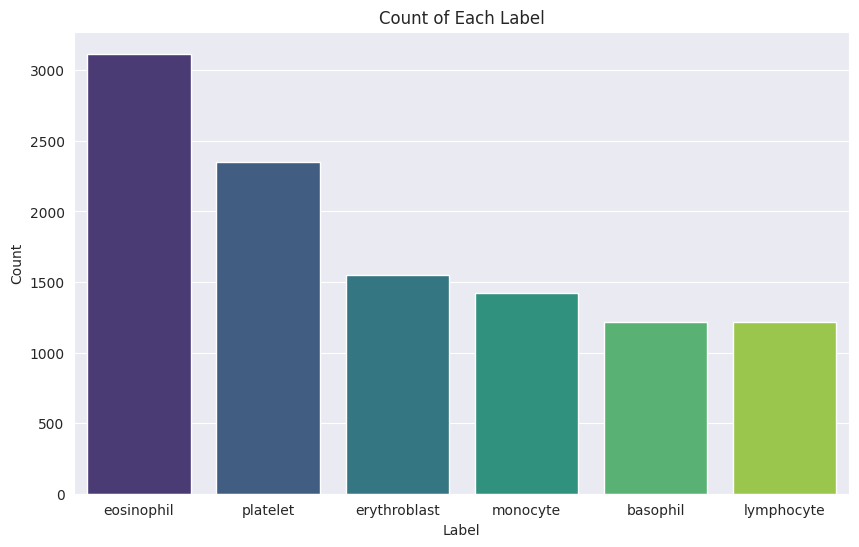

In [7]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='labels', y='count', data=labelscount, palette='viridis')

# Add title and labels
plt.title('Count of Each Label')
plt.xlabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

# Preprocessing

In [8]:
df

,filepaths,labels
0,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
1,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
2,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
3,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
4,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
...,...,...
10863,/kaggle/input/blood-cells-image-dataset/bloodc...,platelet
10864,/kaggle/input/blood-cells-image-dataset/bloodc...,platelet
10865,/kaggle/input/blood-cells-image-dataset/bloodc...,platelet
10866,/kaggle/input/blood-cells-image-dataset/bloodc...,platelet


<h2>Train Test Valid Split<h2>

In [9]:
# train dataframe
train_df, dummy_df = train_test_split(df,  test_size= 0.2, shuffle= True, random_state= 43)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 43)

In [10]:
train_df

,filepaths,labels
7570,/kaggle/input/blood-cells-image-dataset/bloodc...,eosinophil
4948,/kaggle/input/blood-cells-image-dataset/bloodc...,erythroblast
6175,/kaggle/input/blood-cells-image-dataset/bloodc...,eosinophil
6560,/kaggle/input/blood-cells-image-dataset/bloodc...,eosinophil
745,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
...,...,...
2064,/kaggle/input/blood-cells-image-dataset/bloodc...,basophil
10517,/kaggle/input/blood-cells-image-dataset/bloodc...,platelet
7985,/kaggle/input/blood-cells-image-dataset/bloodc...,eosinophil
2303,/kaggle/input/blood-cells-image-dataset/bloodc...,basophil


In [11]:
dummy_df

,filepaths,labels
2052,/kaggle/input/blood-cells-image-dataset/bloodc...,basophil
8443,/kaggle/input/blood-cells-image-dataset/bloodc...,eosinophil
1805,/kaggle/input/blood-cells-image-dataset/bloodc...,basophil
7883,/kaggle/input/blood-cells-image-dataset/bloodc...,eosinophil
3709,/kaggle/input/blood-cells-image-dataset/bloodc...,lymphocyte
...,...,...
6650,/kaggle/input/blood-cells-image-dataset/bloodc...,eosinophil
7653,/kaggle/input/blood-cells-image-dataset/bloodc...,eosinophil
1275,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
10413,/kaggle/input/blood-cells-image-dataset/bloodc...,platelet


In [12]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8694 validated image filenames belonging to 6 classes.
Found 1087 validated image filenames belonging to 6 classes.
Found 1087 validated image filenames belonging to 6 classes.


**Show some pics from Data**

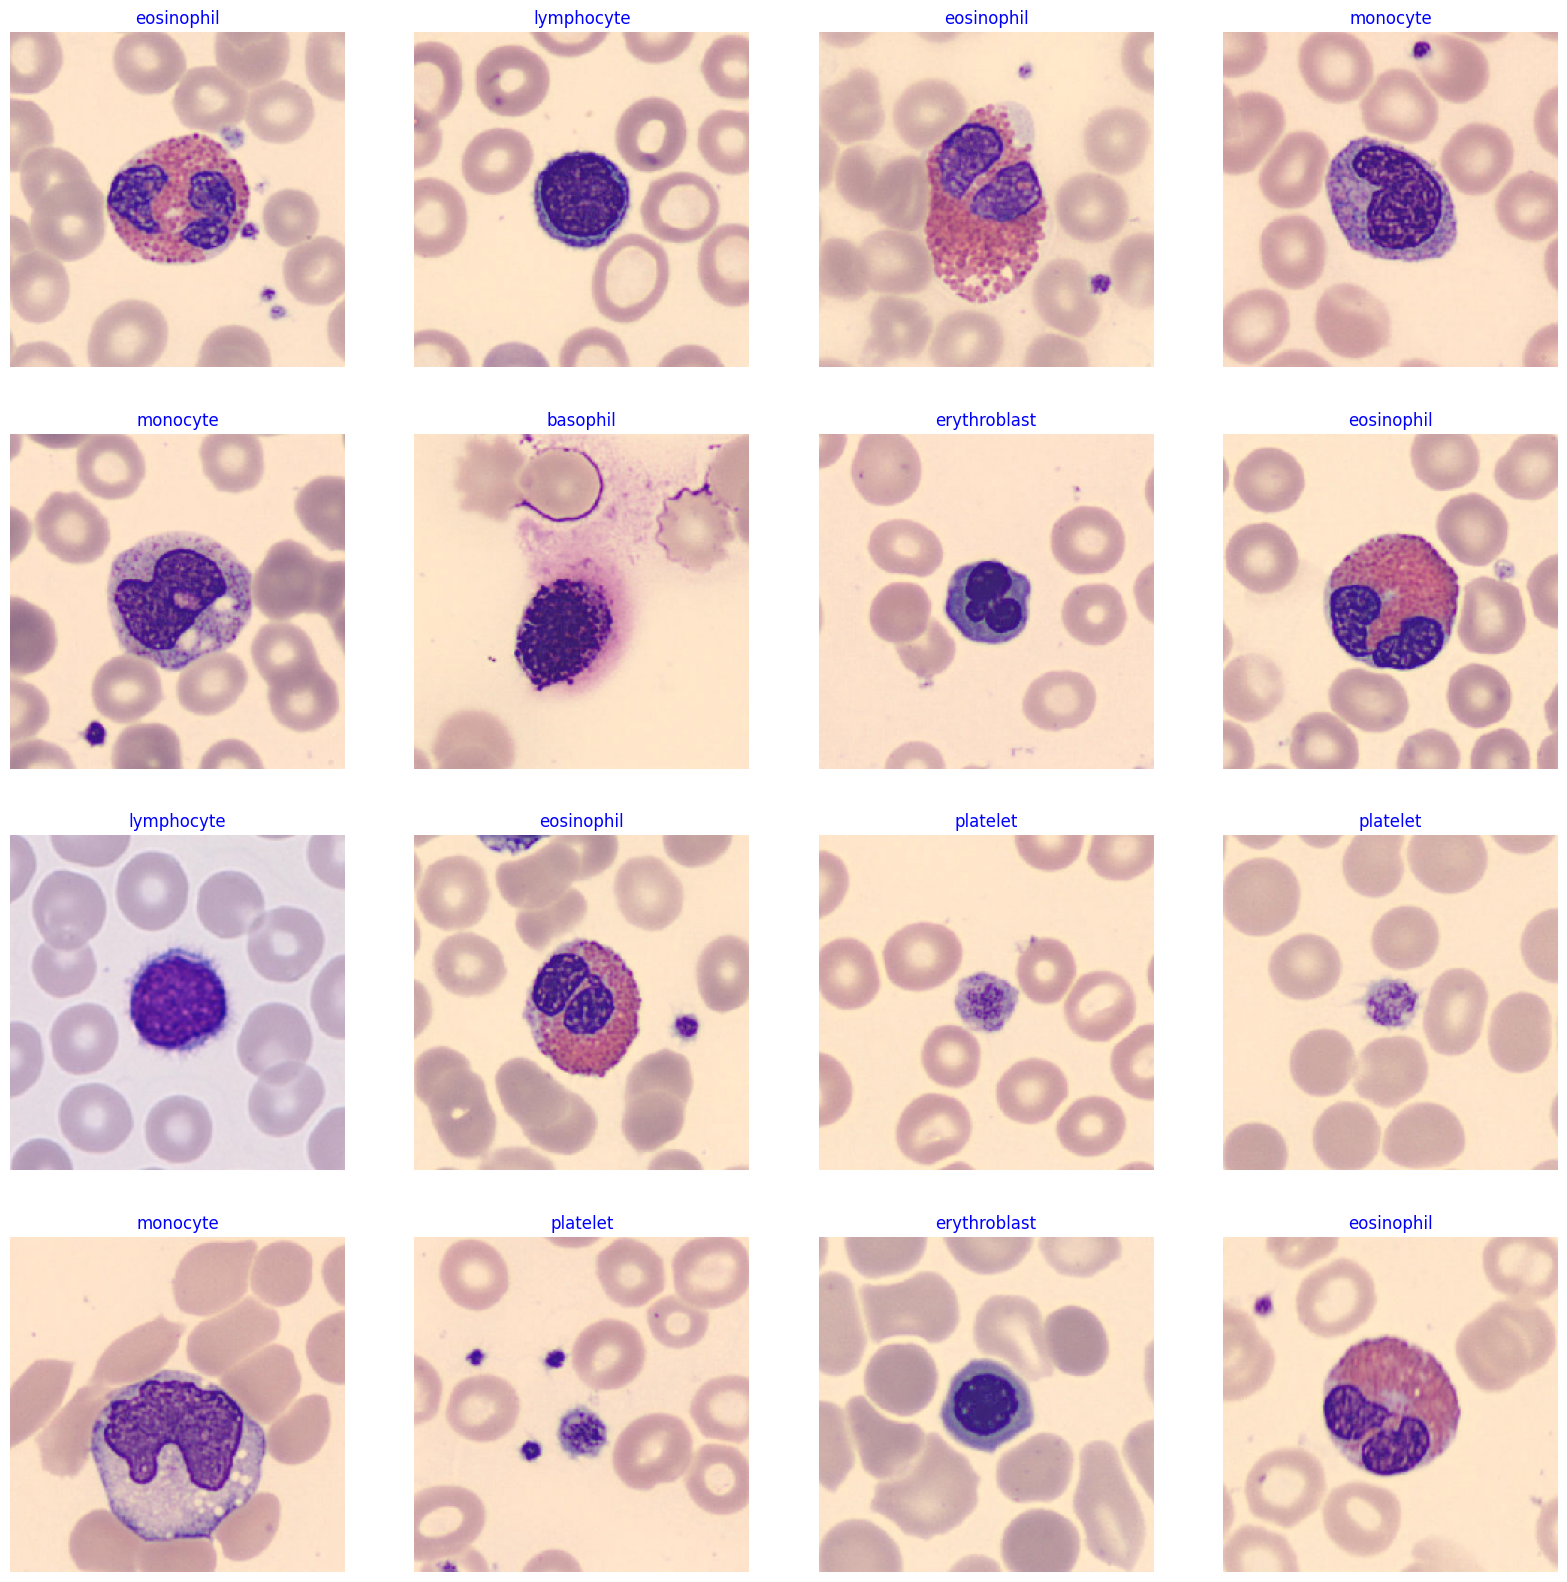

In [13]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Build The Model CNN

In [14]:
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer
model = Sequential([
    tf.keras.Input(shape=(img_size[0], img_size[1], channels)),
    tf.keras.layers.Rescaling(1./255),  # Rescale input values to [0, 1]
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(train_gen, epochs= 5, verbose= 1, validation_data= valid_gen, shuffle = False)

Epoch 1/5


2024-07-13 21:56:38.592689: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148273: 4.10347, expected 3.58648
2024-07-13 21:56:38.592756: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149075: 3.91455, expected 3.39756
2024-07-13 21:56:38.592772: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149093: 3.88055, expected 3.36356
2024-07-13 21:56:38.592791: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149362: 4.10975, expected 3.59276
2024-07-13 21:56:38.592806: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149850: 3.98709, expected 3.4701
2024-07-13 21:56:38.592831: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 151973: 3.89678, expected 3.37979
2024-07-13 21:56:38.592849: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 153061: 4.10204, expected 3.58504
2024-07-13 21:56:38.5

  3/544 ━━━━━━━━━━━━━━━━━━━━ 34s 64ms/step - accuracy: 0.1944 - loss: 4.7365  

I0000 00:00:1720907802.906585      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720907802.926867      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


543/544 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5804 - loss: 1.2221

2024-07-13 21:57:33.344803: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.75633, expected 4.15703
2024-07-13 21:57:33.344866: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 4.83207, expected 4.23277
2024-07-13 21:57:33.344881: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 4.497, expected 3.89771
2024-07-13 21:57:33.344894: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 83: 4.81993, expected 4.22063
2024-07-13 21:57:33.344905: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180: 4.77272, expected 4.17342
2024-07-13 21:57:33.344927: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 181: 4.95521, expected 4.35591
2024-07-13 21:57:33.344939: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 182: 4.92335, expected 4.32405
2024-07-13 21:57:33.344949: E external/local_xl

544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5806 - loss: 1.2214

W0000 00:00:1720907856.955223      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-07-13 21:57:42.968680: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 7.61846, expected 6.73536
2024-07-13 21:57:42.968749: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 7.75449, expected 6.8714
2024-07-13 21:57:42.968758: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 6.77945, expected 5.89635
2024-07-13 21:57:42.968767: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.42989, expected 5.54679
2024-07-13 21:57:42.968774: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49292: 7.06139, expected 6.17829
2024-07-13 21:57:42.968782: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49293: 7.03813, expected 6.15504
2024-07-13 21:57:42.968790: E external/loc

544/544 ━━━━━━━━━━━━━━━━━━━━ 69s 113ms/step - accuracy: 0.5809 - loss: 1.2207 - val_accuracy: 0.7866 - val_loss: 1.0656
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.8760 - loss: 0.3699 - val_accuracy: 0.9338 - val_loss: 0.8551
Epoch 3/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.9429 - loss: 0.1750 - val_accuracy: 0.9200 - val_loss: 0.6248
Epoch 4/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.9627 - loss: 0.1147 - val_accuracy: 0.9200 - val_loss: 0.6250
Epoch 5/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.9714 - loss: 0.0943 - val_accuracy: 0.9577 - val_loss: 0.8185


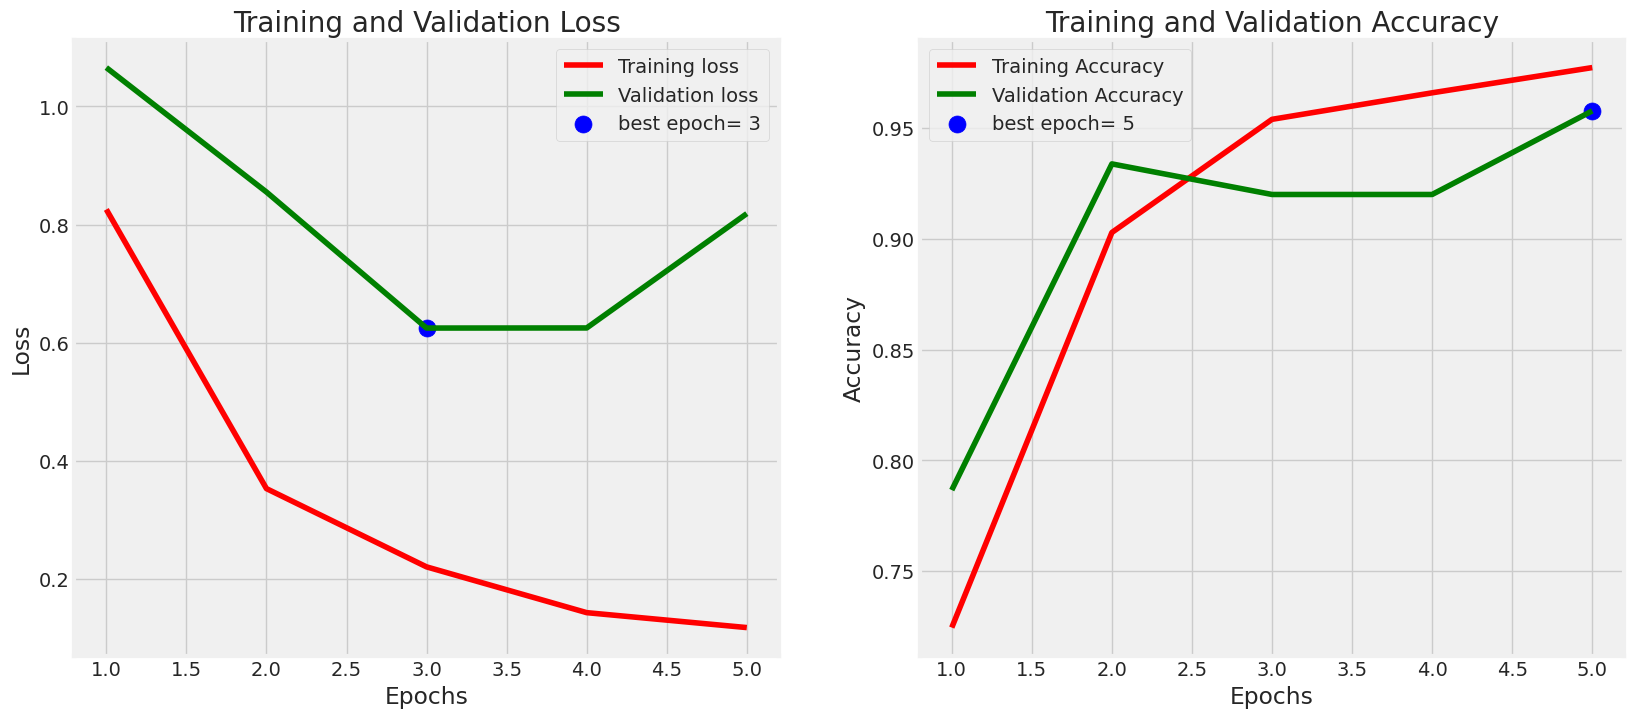

In [17]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate model

In [18]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9850 - loss: 0.0693
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9588 - loss: 0.7252  
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9756 - loss: 0.6633   
Train Loss:  0.08656127750873566
Train Accuracy:  0.9857372641563416
--------------------
Validation Loss:  0.7666946649551392
Validation Accuracy:  0.9586016535758972
--------------------
Test Loss:  0.7024371027946472
Test Accuracy:  0.9751610159873962


<h2>Get Predictions<h2>

In [19]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

 6/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step

W0000 00:00:1720907983.677965      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


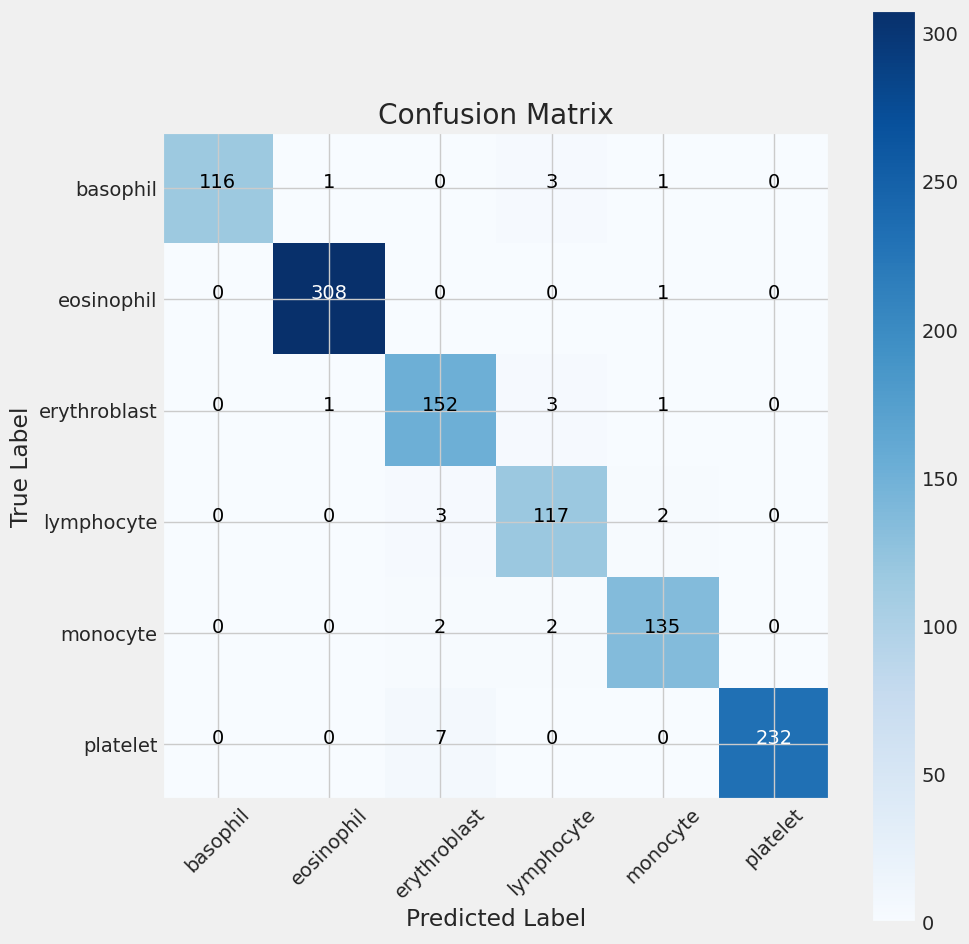

In [20]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [21]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    basophil       1.00      0.96      0.98       121
  eosinophil       0.99      1.00      1.00       309
erythroblast       0.93      0.97      0.95       157
  lymphocyte       0.94      0.96      0.95       122
    monocyte       0.96      0.97      0.97       139
    platelet       1.00      0.97      0.99       239

    accuracy                           0.98      1087
   macro avg       0.97      0.97      0.97      1087
weighted avg       0.98      0.98      0.98      1087



# Pre Trained Model Using EfficientNetB3

In [22]:

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can build on pretrained model such as : efficientnet, VGG, Resnet)
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
model.build(input_shape=(None, *img_shape))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,693 (42.67 MB)

 Trainable params: 11,094,318 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [24]:
history = model.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 328s 331ms/step - accuracy: 0.4143 - loss: 9.6528 - val_accuracy: 0.4931 - val_loss: 4.8584
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 75s 137ms/step - accuracy: 0.4642 - loss: 4.2684 - val_accuracy: 0.4949 - val_loss: 2.8533
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 75s 138ms/step - accuracy: 0.4891 - loss: 2.6165 - val_accuracy: 0.6063 - val_loss: 2.0069
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 75s 139ms/step - accuracy: 0.5894 - loss: 1.8441 - val_accuracy: 0.8841 - val_loss: 1.3530
Epoch 5/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 81s 137ms/step - accuracy: 0.8520 - loss: 1.3403 - val_accuracy: 0.9660 - val_loss: 0.9165
Epoch 6/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 75s 137ms/step - accuracy: 0.9414 - loss: 1.0084 - val_accuracy: 0.9908 - val_loss: 0.7083
Epoch 7/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 74s 137ms/step - accuracy: 0.9358 - loss: 0.8838 - val_accuracy: 0.9853 - val_loss: 0.6122
Epoch 8/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 75s 138ms/step - accuracy: 0.9522 - loss: 

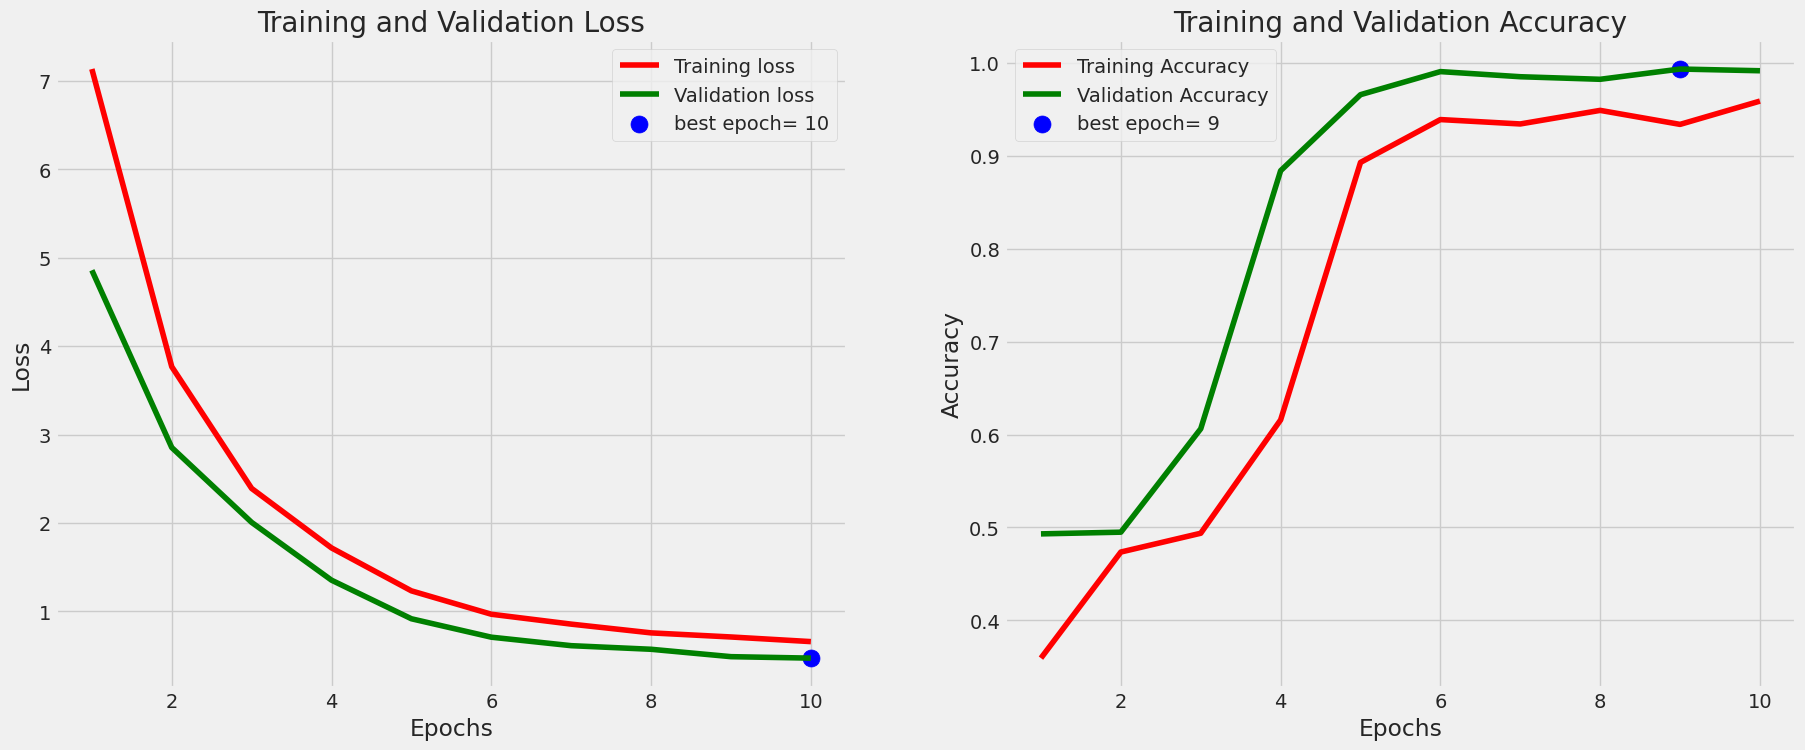

In [25]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate Pretrainedmodel

In [26]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.9951 - loss: 0.4665
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9914 - loss: 0.4720  
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9962 - loss: 0.4593  
Train Loss:  0.46778053045272827
Train Accuracy:  0.9947090148925781
--------------------
Validation Loss:  0.47136104106903076
Validation Accuracy:  0.9917203187942505
--------------------
Test Loss:  0.4592363238334656
Test Accuracy:  0.9963201284408569


<h2>Get Predictions<h2>

In [27]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step


<h2>Confusion Matrics and Classification Report<h2>

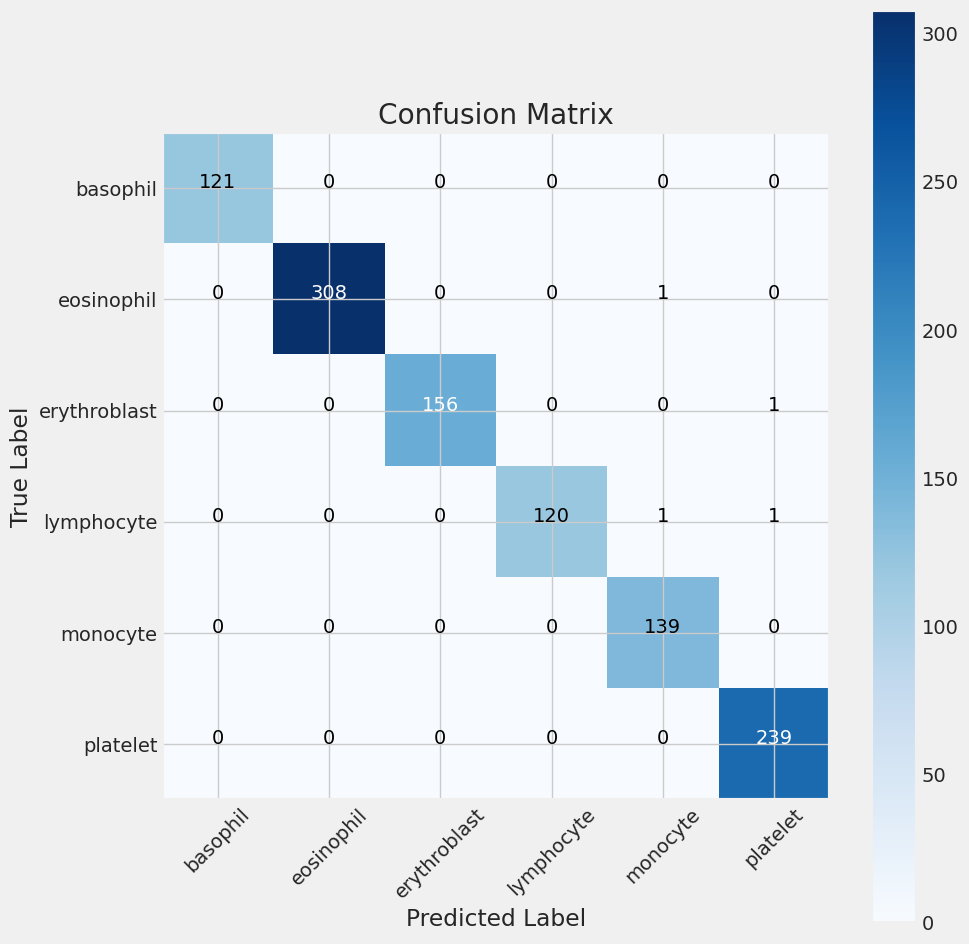

In [28]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [29]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    basophil       1.00      1.00      1.00       121
  eosinophil       1.00      1.00      1.00       309
erythroblast       1.00      0.99      1.00       157
  lymphocyte       1.00      0.98      0.99       122
    monocyte       0.99      1.00      0.99       139
    platelet       0.99      1.00      1.00       239

    accuracy                           1.00      1087
   macro avg       1.00      1.00      1.00      1087
weighted avg       1.00      1.00      1.00      1087

